In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set() # use seaborn plotting defaults
from sklearn.datasets.samples_generator import make_blobs
from sklearn.svm import SVC # support vector classifier
from ipywidgets import interact, fixed
from sklearn.datasets.samples_generator import make_circles
from mpl_toolkits import mplot3d
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Populating the interactive namespace from numpy and matplotlib


https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

https://monzersaleh.github.io/001_Classification_SVM.html

https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/

### Motivation

*Generative classification:* Some classifiers model the underlying distribution of different groups of data, then use those models to probabilistically determine classifications for new data points.

*Discriminative classification:* SVM will instead find a line, curve, or manifold that divides the different groups of data in 2D (or higher dimensional) space.

### Make the data

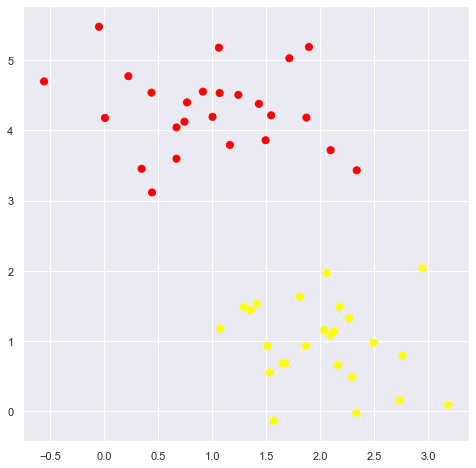

In [2]:
# make some junk data that doesn't have any actual meaning
plt.figure(figsize=(8,8))
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60) # X = coordinates in 2D space // y = classification label
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

In [3]:
print(" X: ", X[0:5],"\n", "y: ", y[0:5]) # X contains coordinate pairs, y contains labels

 X:  [[1.41281595 1.5303347 ]
 [1.81336135 1.6311307 ]
 [1.43289271 4.37679234]
 [1.87271752 4.18069237]
 [2.09517785 1.0791468 ]] 
 y:  [1 1 0 0 1]


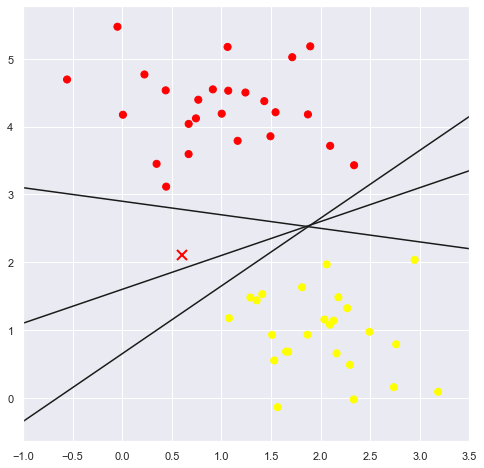

In [4]:
plt.figure(figsize=(8,8))
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

# these two classes can obviously be separated in 2D space by a straight line.
# but which straight line should we use?? 
# our choice of line will affect the classification of the new data point marked by an "x", so it can't just be an arbitrary decision...

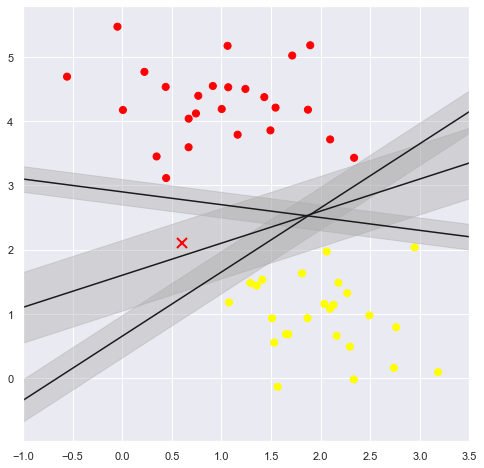

In [5]:
plt.figure(figsize=(8,8))
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

# SVM will choose the decision boundary with the maximum "margin"
# In plain terms, we want the line that 
#       (1) separates the two classes 
#                   AND 
#       (2) stays as far away from the data points as possible

# see https://towardsdatascience.com/support-vector-machine-python-example-d67d9b63f1c8 for the math behind calculating the maximum margin

### Training the (Linear) SVM classifier

#### Aside: kernels

SVM algorithms use a set of mathematical functions that are defined as the "kernel". The function of kernel is to take data as input and transform it into the required form.

Possible kernels include: linear, polynomial, radial basis function (rbf), sigmoid kernel, or the option to define your own kernel

In [6]:
# create instance of SVM classifier with a linear kernel and a large value for C
model = SVC(kernel='linear', C=1E10)
# fit the model to our data
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [7]:
# for our convenience, define a function to visualize SVM decision boundaries
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:                                                                                                # had to add edgecolors arg
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=300, linewidth=1, facecolors='none', edgecolors='black');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

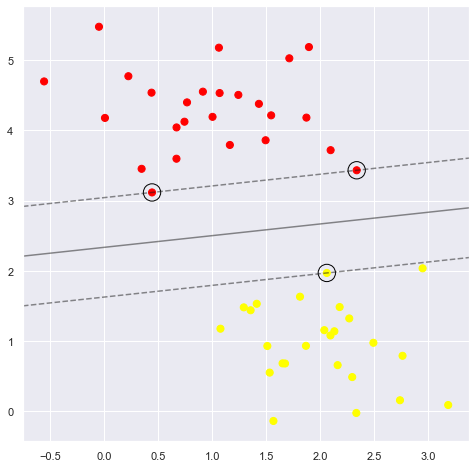

In [8]:
plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

In [9]:
# there are three "support vectors" - the points that actually matter to the SVM
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

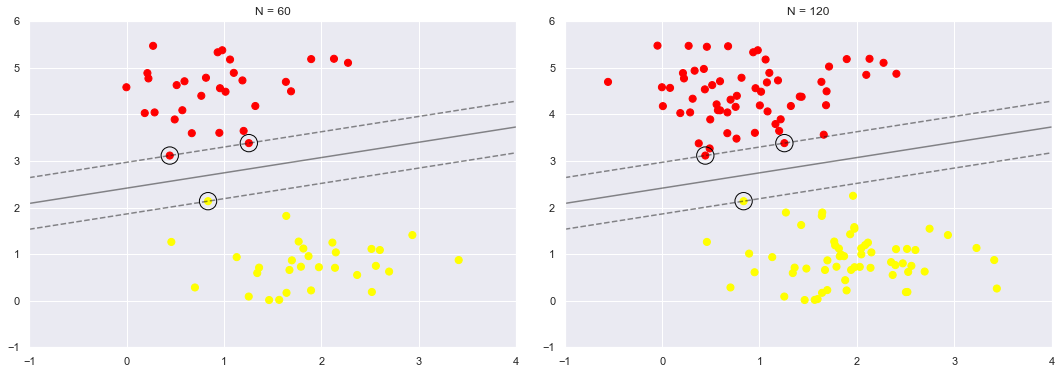

In [10]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2, random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))
    
# the support vectors remain the same regardless of additional data (that don't cross the boundary, of course)
# insensivity to *distant* points is a strength of SVM

In [11]:
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

### Comparing different kernels

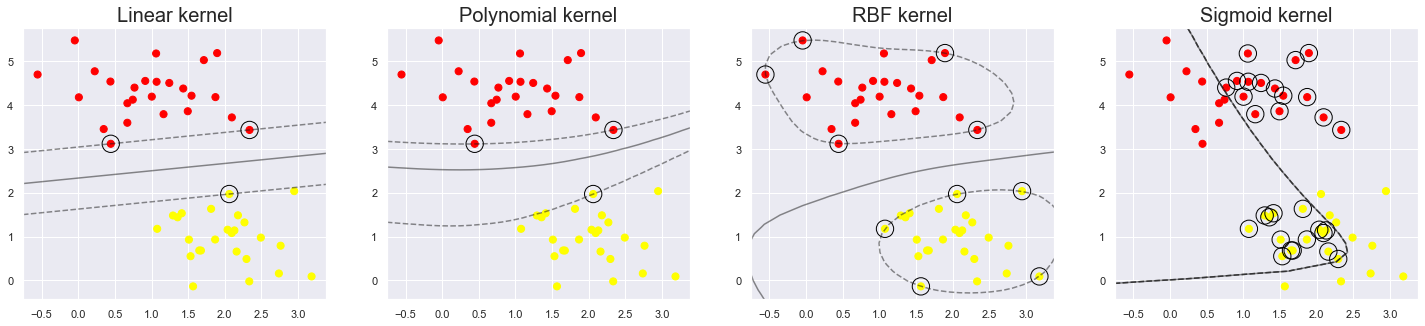

In [12]:
model_lin = SVC(kernel='linear', C=1E10); model_lin.fit(X, y)
model_poly = SVC(kernel='poly', C=1E10); model_poly.fit(X, y)
model_rbf = SVC(kernel='rbf', C=1E10); model_rbf.fit(X, y)
model_sig = SVC(kernel='sigmoid', C=1E10); model_sig.fit(X, y)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 5))
ax1.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
ax1.set_title("Linear kernel", fontsize=20)
plot_svc_decision_function(model_lin,ax1)
ax2.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
ax2.set_title("Polynomial kernel", fontsize=20)
plot_svc_decision_function(model_poly,ax2)
ax3.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
ax3.set_title("RBF kernel", fontsize=20)
plot_svc_decision_function(model_rbf,ax3)
ax4.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
ax4.set_title("Sigmoid kernel", fontsize=20)
plot_svc_decision_function(model_sig,ax4)

### Beyond linear boundaries

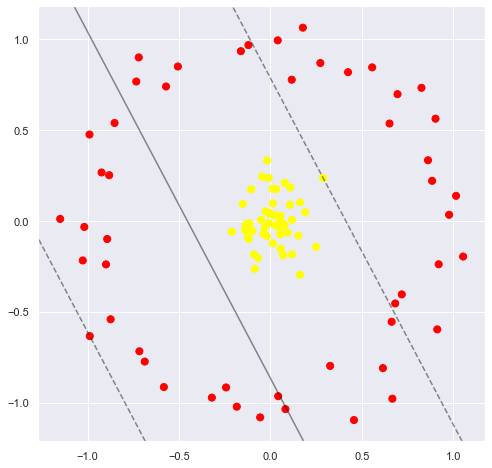

In [13]:
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

### Radial basis function

In [14]:
# Want to project the data into a higher dimension in order to use a linear separator 
# One simple projection is a *radial basis function* centered on the middle clump:
r = np.exp(-(X ** 2).sum(1))

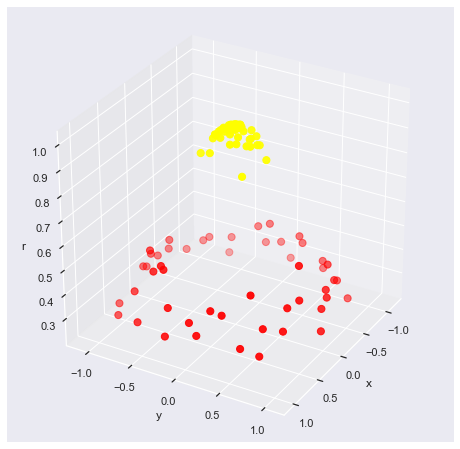

In [15]:
def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('r')

plt.figure(figsize=(8,8))
plot_3D()

#interact(plot_3D, elev=[-90, 90], azip=(-180, 180), X=fixed(X), y=fixed(y));

# When we project the data to 3D space, we see that a separating plane at, for example, r = 0.7 would easily separate the data
# But, if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results
# Luckily, the SVM has the power to pick the right radial basis function for us
# The SVM computes a basis function centered at every point in the dataset and picks the best one
# The *kernel trick* helps prevent this process from becoming too computationally intensive

### Training SVM classifier

In [16]:
# choose rbf for our now non-linearly separable data. SVM will pick best rbf for us
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

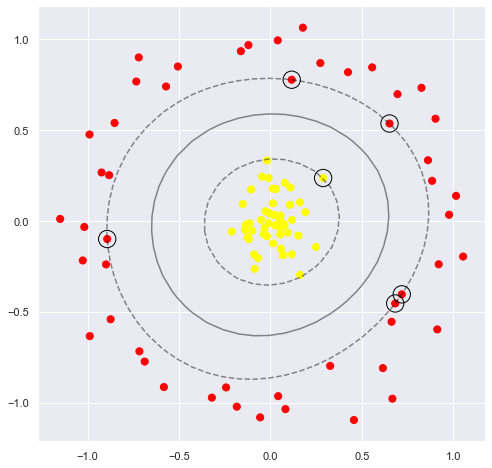

In [17]:
plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)

### Tuning the SVM: softening margins

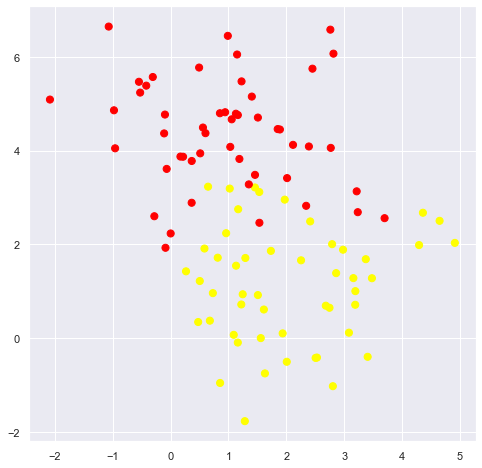

In [18]:
plt.figure(figsize=(8,8))
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

# What if our data has overlapping groups?

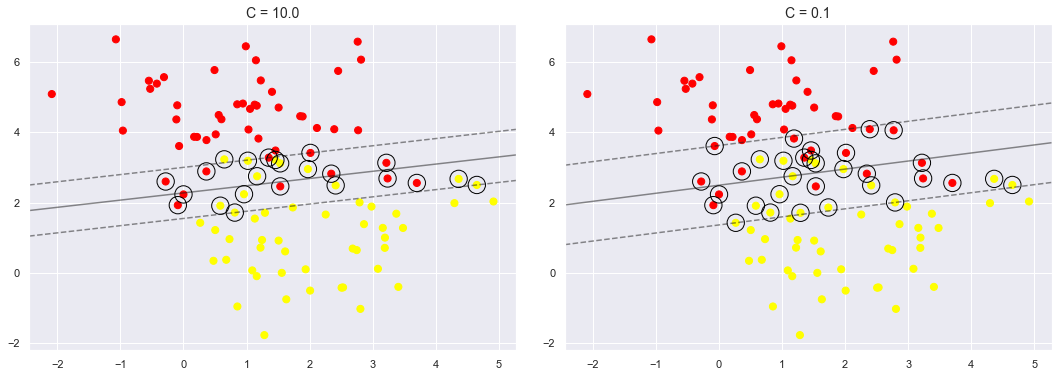

In [19]:
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=1.2)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)
    
# The tuning parameter (C) that "softens" the margin: it allows some of the points to creep into the margin if that allows a better fit. 
# For very large C, the margin is hard, and points cannot lie in it. For smaller C, the margin is softer, and can grow to encompass some points.

In [20]:
#The following snippet comes from the SKLearn documentation on the SVM. 
#It demonstrates how to calibrate the variable C which affects the margins of the SVM classifier

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)

param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 100.0, 'gamma': 1.0} with a score of 0.96


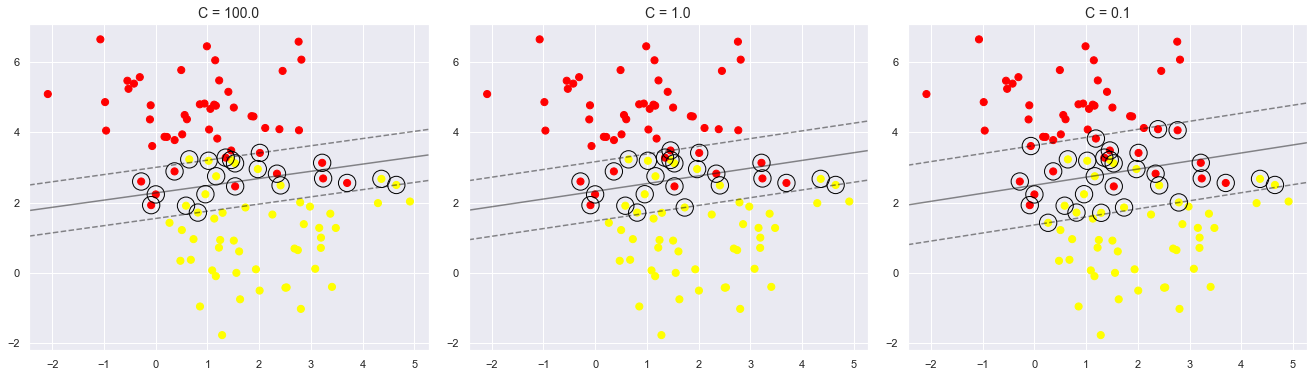

In [21]:
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=1.2)

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [100.0, 1.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)